# はじめに


[Software Design 2018年10月号](https://gihyo.jp/magazine/SD/archive/2018/201810)掲載『平林万能IT技術研究所 地球のどこでも「この瞬間に街を流れる風」を可視化せよ！』では，建物の周りの風を2次元Navier-Stokes方程式を解いて計算している。手順は以下の通りである。

1. [OpenWeatherMap](https://openweathermap.org)から指定した緯度経度近傍の風向・風速データを取得
1. [OpenStreetMap](https://www.openstreetmap.org)を画像処理して流体計算から除く建物マスクを生成
1. 2次元Navier-Stokes方程式ソルバを実行
1. Matplotlibで可視化

あとで述べるように，風向・風速データはアメダスを使っても良いし，自分で指定しても良い。OpenStreetMapには建物のデータが入っていない地域もあるが，基盤地図情報など別の情報からマスクを作成しても良い。このノートブックでは，[CFDPython](https://bitbucket.org/cfdpython/cfd-python-class/overview)に従って，流体ソルバを作成したあと，アメダスデータとOpenStreeMapのデータを用いた風の流れを計算する。最後に基盤地図情報とアメダスデータを用いた風の計算について紹介する。OpenWeatherMapからのデータ取得については，平林氏の記事を参照のこと。

## 注意

地図が描かれてもっともらしい図が描かれるが，極端に単純化した2次元での計算である。表面での摩擦やすなわち建物を越えるような3次元の流れは考慮されていない。現実と対応させるには，注意が必要である。

## 参考としたURL

* [CFDPython (bitbucket)](https://bitbucket.org/cfdpython/cfd-python-class/overview): 関連するStep 11がある。
* [CFDPython (github)](https://github.com/barbagroup/CFDPython): 新しいがStep 11がない。
* [hirax/BlowinInTheWindAtAnywhereYouWant](https://github.com/hirax/BlowinInTheWindAtAnywhereYouWant)

# 支配方程式系

非圧縮性を仮定すると，2次元のNavier-Stokes方程式と連続の式は次のように書ける。
\begin{align}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} &= -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} &= -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right) \\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0
\end{align}
$u$の式を$x$で$v$の式を$y$で微分し，連続の式を適用すると，$p$に対するPoisson方程式を得る。
\begin{equation}
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x} + 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} + \frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
\end{equation}

## 気圧に対するPoisson方程式

\begin{equation}
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = b
\end{equation}
を解く。差分形は次のようになる。
\begin{equation}
\frac{p_{i+1,j} - 2p_{i, j} + p_{i-1, j}}{\Delta x^2} + \frac{p_{i, j+1} - 2p_{i, j} + p_{i, j-1}}{\Delta y^2} = b_{i, j}
\end{equation}
両辺に$\Delta x^2\Delta y^2$をかけて，$p_{i,j}$について整理すると
\begin{equation}
p_{i, j} = \frac{(p_{i+1, j}+p_{i-1, j})\Delta y^2 + (p_{i, j+1} + p_{i, j-1})\Delta x^2 - b_{i, j}\Delta x^2\Delta y^2}{2(\Delta x^2 + \Delta y^2)}
\end{equation}
右辺は
\begin{equation}
b_{i,j} = -\rho\left[\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\right)^2 + 2 \frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} + \left(\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)^2\right]
\end{equation}
となるが，計算安定性のため（?）連続の式の$-\rho/\Delta t$倍を加える。
\begin{equation}
b_{i,j} = -\rho\left[\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\right)^2 + 2 \frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} + \left(\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)^2 - \frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{\Delta x} + \frac{v_{i,j+1}-v_{i,j-1}}{\Delta y}\right)\right]
\end{equation}

In [1]:
# x[j, i]
import numpy as np

tolerance = 1.0e-5
def solve_poisson(p, dx, dy, b, n = 100):
    dxdx = dx * dx
    dydy = dy * dy
    e = np.empty_like(p)
    k = 1
    while True:
        pn = p.copy()
        p[1:-1, 1:-1] = ((pn[1:-1, 2:] + pn[1:-1, :-2]) * dydy +
               (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dxdx -
                b[1:-1, 1:-1] * dxdx * dydy) / (2 * (dxdx + dydy))
        p[:, 0]  = p[:, 1] # dp/dx = 0 at x = 0
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = end
        p[0, :]  = p[1, :] # dp/dy = 0 at y = 0
        p[-1, :] = p[-2, :] # dp/ dy = 0 at y = end
        e = p - pn
        if np.all(e < tolerance) or k > n:
            break
        k += 1
    return p

def build_rhs(rho, dt, u, v, dx, dy):
    b = np.empty_like(u)
    dx2 = 2 * dx
    dy2 = 2 * dy
    b[1:-1, 1:-1] = -rho * ( \
        ((u[1:-1, 2:] - u[1:-1, :-2]) / dx2) ** 2 \
        + (u[2:, 1:-1] - u[:-2, 1:-1]) * (v[1:-1, 2:] - v[1:-1, :-2]) / (dx2 * dy) \
        + ((v[2:, 1:-1] - v[:-2, 1:-1]) / dy2) **2 \
        - ((u[1:-1, 2:] - u[1:-1, :-2]) / dx2 + (v[2:, 1:-1] - v[:-2, 1:-1]) / dy2) / dt)
    return b

## Navier-Stokes方程式の差分形

時間積分は前方差分（Euler法），空間差分は，移流項が後方差分，気圧傾度力項が中央差分，粘性項も1次。境界条件は`ub`, `vb`に与える。1ステップだけ計算し，マスク処理はソルバを実行する関数に任せる。

\begin{align}
u_{i,j}^{n+1} &= u_{i,j}^n -\Delta t
\left\{
  u_{i, j} \frac{u_{i,j} - u_{i-1, j}}{\Delta x} 
 + v_{i, j} \frac{u_{i,j} - u_{i, j-1}}{\Delta y}
 +\frac{1}{\rho}\frac{p_{i+1, j} - p_{i-1, j}}{2\Delta x}
 -\nu\left(\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^2} +
   \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{\Delta y^2}\right)\right\} \\
v_{i,j}^{n+1} &= u_{i,j}^n - \Delta t
\left\{
  u_{i, j} \frac{v_{i, j} - v_{i-1, j}}{\Delta x} 
 + v_{i, j} \frac{v_{i,j} -v_{i, j-1}}{\Delta y}
 +\frac{1}{\rho}\frac{p_{i, j+1} - p_{i, j-1}}{2\Delta y}
 -\nu\left(\frac{v_{i+1,j} - 2v_{i,j} + v_{i-1,j}}{\Delta x^2} +
   \frac{v_{i,j+1} - 2v_{i,j} + v_{i,j-1}}{\Delta y^2}\right)\right\}
\end{align}

In [2]:
def step(u, v, p, rho, nu, dt, dx, dy, ub, vb):
    b = build_rhs(rho, dt, u, v, dx, dy)
    p = solve_poisson(p, dx, dy, b)
    un = u.copy()
    vn = v.copy()
    u[1:-1, 1:-1] = un[1:-1, 1:-1] - dt * (
        un[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) / dx + \
        vn[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) / dy + \
        (p[1:-1, 2:] - p[1:-1, :-2]) / (2 * rho * dx) - \
        nu * ((un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) / (dx ** 2) +
              (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) / (dy ** 2)))
    v[1:-1, 1:-1] =vn[1:-1, 1:-1] - dt * (
        un[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) / dx + \
        vn[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) / dy + \
        (p[2:, 1:-1] - p[:-2, 1:-1]) / (2 * rho * dx) - \
        nu * ((vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) / (dx ** 2) +
              (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) / (dy ** 2)))
    u[0,  :] = ub
    v[0,  :] = vb    
    u[:, -1] = ub
    v[:, -1] = vb
    u[:,  0] = ub
    v[:,  0] = vb
    u[-1, :] = ub
    v[-1, :] = vb
    return u, v, p

マスク作成はループを避けた書き方に変更した。

In [3]:
def mask_velocity(u, v, mask):
    u[mask == 255] = 0.0
    v[mask == 255] = 0.0
    return u, v

ソルバを実行する関数では，実験パラメタは引数で与えられるように変更した。

In [4]:
def run_ns2d(speed, angle_deg, mask, rho = 1, nu = 0.1, dt = 1.0e-5, nt = 20):
    ub = -np.sin(np.deg2rad(angle_deg)) * speed
    vb = -np.cos(np.deg2rad(angle_deg)) * speed
    ny, nx = mask.shape
    x, dx = np.linspace(0, 2, nx, retstep = True)
    y, dy = np.linspace(0, 2, ny, retstep = True)
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    for i in np.arange(nt):
        u, v = mask_velocity(u, v, mask)
        u, v, p = step(u, v, p, rho, nu, dt, dx, dy, ub, vb)
        u, v = mask_velocity(u, v, mask)
    return u, v, p, np.sqrt(u ** 2 + v ** 2)

# 計算例

## 地図データの取得

指定した場所のタイルを取得。`zoom`は拡大レベル。記事では`19`となっていたが，一つ下を既定とした。必要であれば引数で変更する。画像の取得とリサイズは分離した。

[OpenCV](https://opencv.org)で低解像度画像を作成。MacPortsでは，[opencv](https://github.com/macports/macports-ports/tree/master/graphics/opencv)をインストールするときに`+python36`などとする。`pip`だと[`opecv-python`](https://pypi.org/project/opencv-python/)。

In [5]:
import smopy
import cv2

def get_map_from_osm(lon, lat, ddeg = 0.000001, zoom=18):
    map = smopy.Map((lat, lon, lat + ddeg, lon + ddeg), z=zoom)
    map_image = map.to_numpy()
    return map_image

画像からマスクを作成。HSVに変換し，指定範囲を建物として`255`とし，それ以外を`0`とする。建物データがない地域もある。

In [6]:
import numpy as np
import cv2
def mask_map(map_image):
    hsv = cv2.cvtColor(map_image, cv2.COLOR_BGR2HSV) # convert RGB/BGR to HSV (hue saturation value)
    lower = np.array([100, 19, 100])
    upper = np.array([150, 20, 250])
    mask = cv2.inRange(hsv, lower, upper) # building = 255, other = 0
    masked_map_image = cv2.bitwise_and(map_image, map_image, mask)
    return masked_map_image, mask

京都駅烏丸口付近の地図を取得する。

In [7]:
lon = 135.7598
lat = 34.9872
map_image = get_map_from_osm(lon, lat)

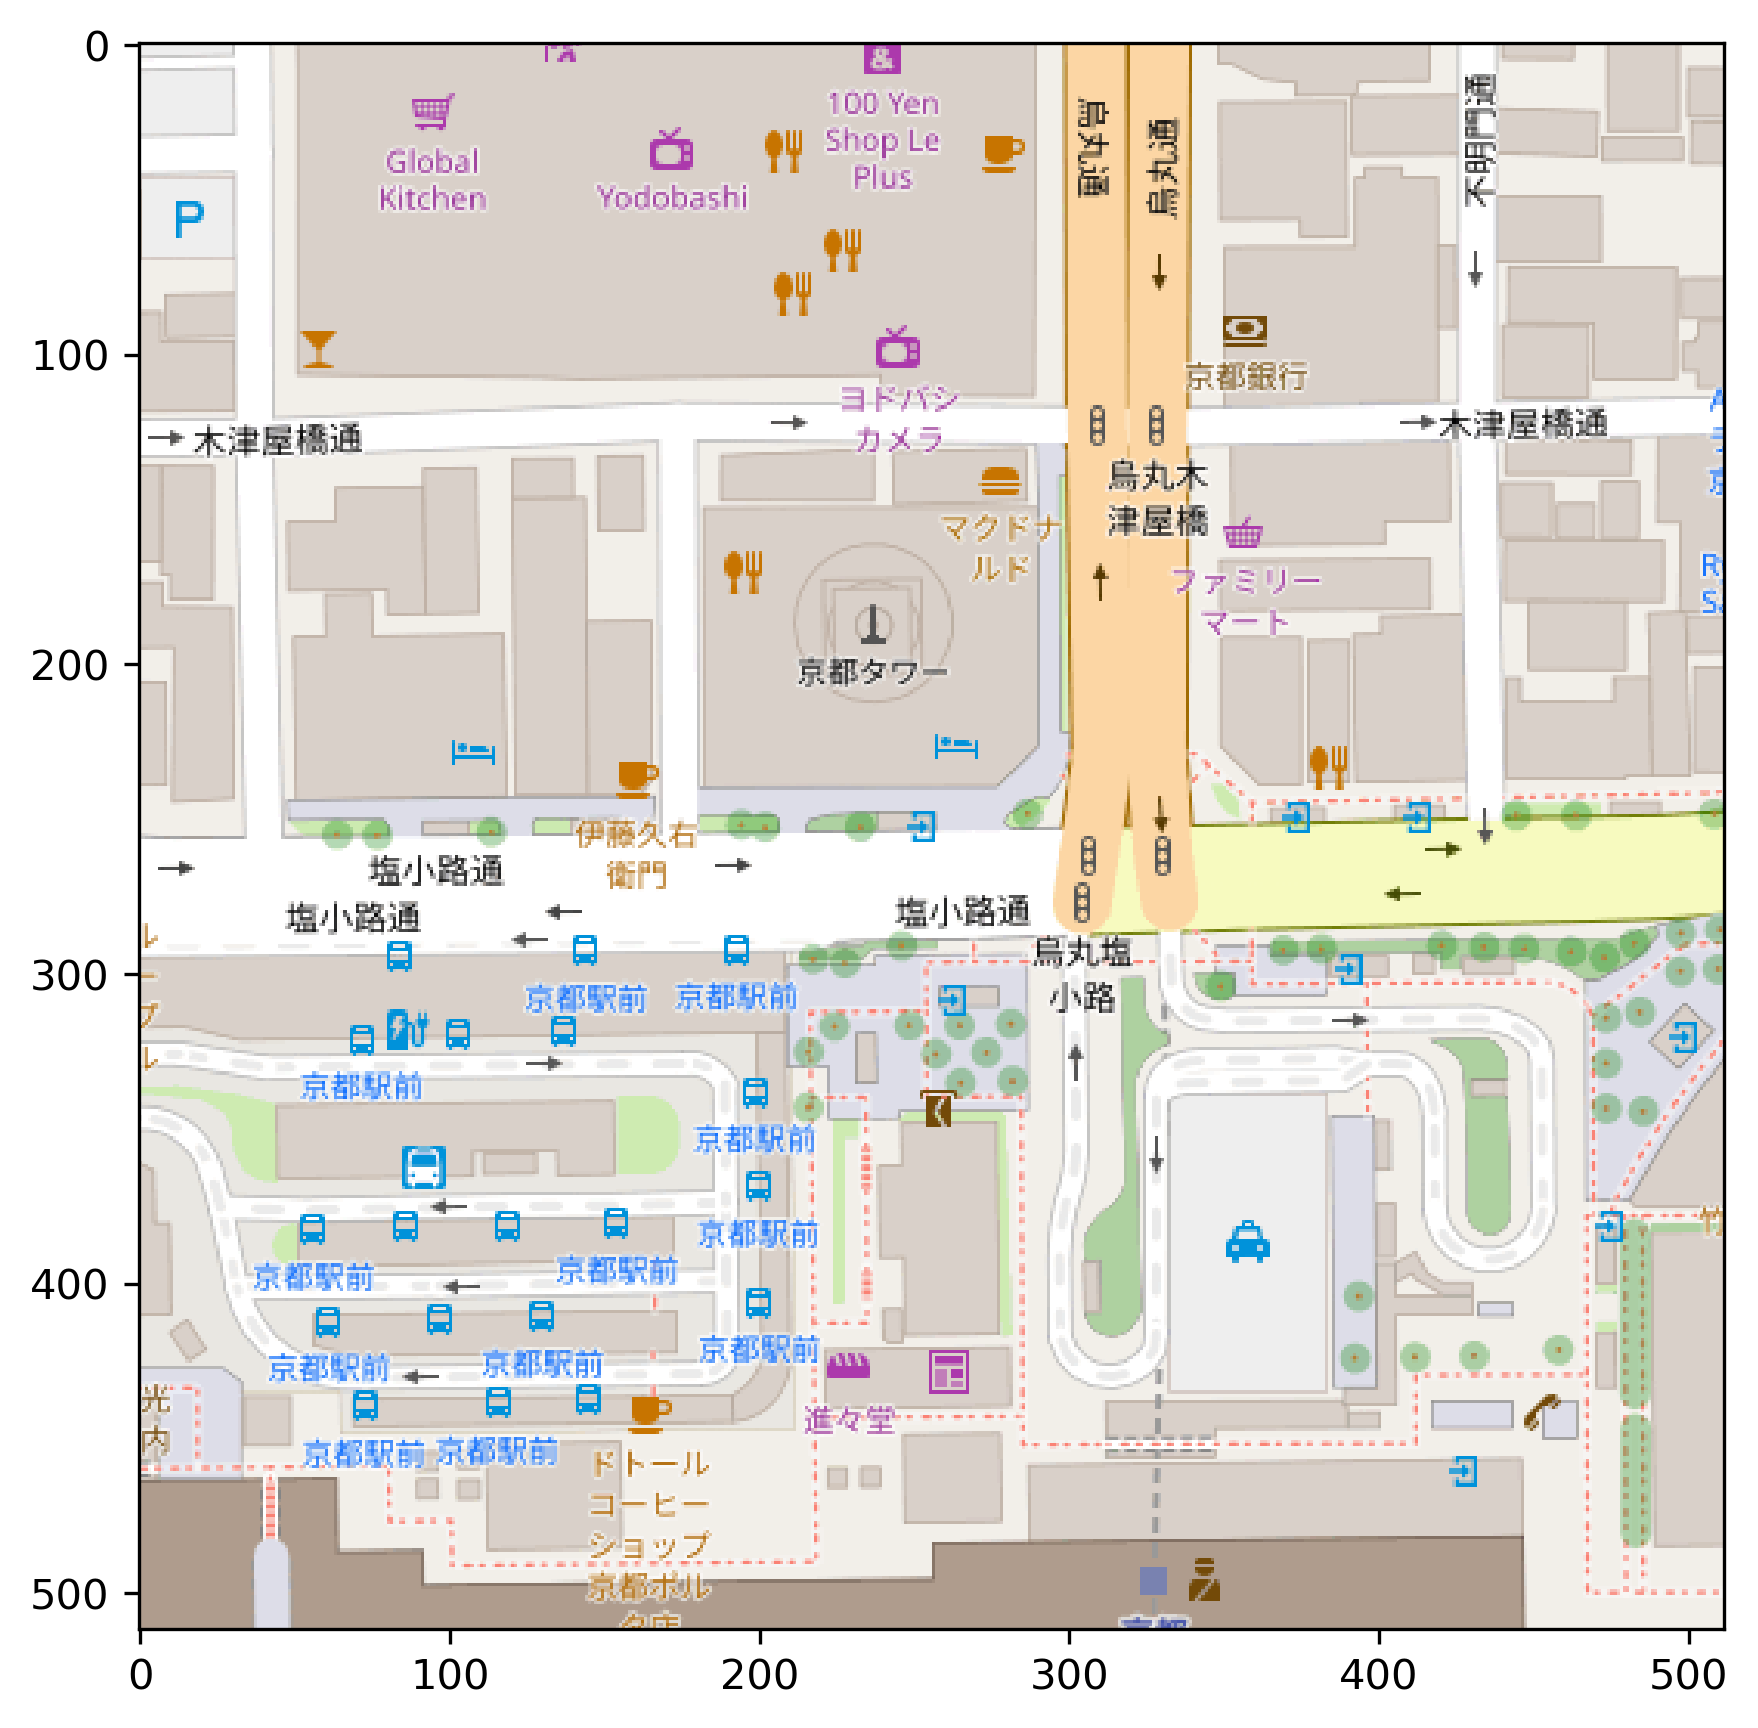

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7), dpi=300)
(npy, npx, _) = map_image.shape
nx = 96
ny = nx * npy // npx
low_image = cv2.resize(map_image, (ny, nx))
plt.imshow(map_image)

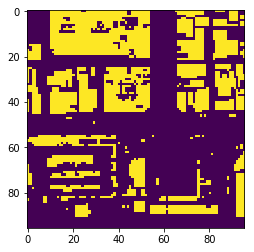

In [9]:
masked_low_image, low_mask = mask_map(low_image)
plt.imshow(low_mask)

In [10]:
low_mask.shape

(96, 96)

[アメダス](http://www.data.jma.go.jp/obd/stats/etrn/view/10min_s1.php?prec_no=61&block_no=47759&year=2018&month=9&day=4&view=)によると，2018年台風第21号Jebiに伴い，京都で14:40ころ最大瞬間風速39.4 m/s（南風）を記録。その条件で計算してみる。

In [11]:
speed = 39.4 # 2018/9/4 14:40 京都
angle = 180.0 # 南
u, v, p, ua = run_ns2d(speed, angle, low_mask)

In [12]:
from matplotlib import cm

def plot_flow(u, v, s, map_image):
    fig = plt.figure(figsize=(11, 7), dpi=300)
    plt.imshow(map_image)
    X, Y = np.meshgrid(np.linspace(0, npx, nx), np.linspace(0, npy, ny))
    plt.contourf(X, Y, ua / speed, alpha=0.2, cmap=cm.jet)
    plt.colorbar()
    plt.quiver(X, Y, u, v)
    plt.streamplot(X, Y, u, -v)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([0, npx])
    plt.show()

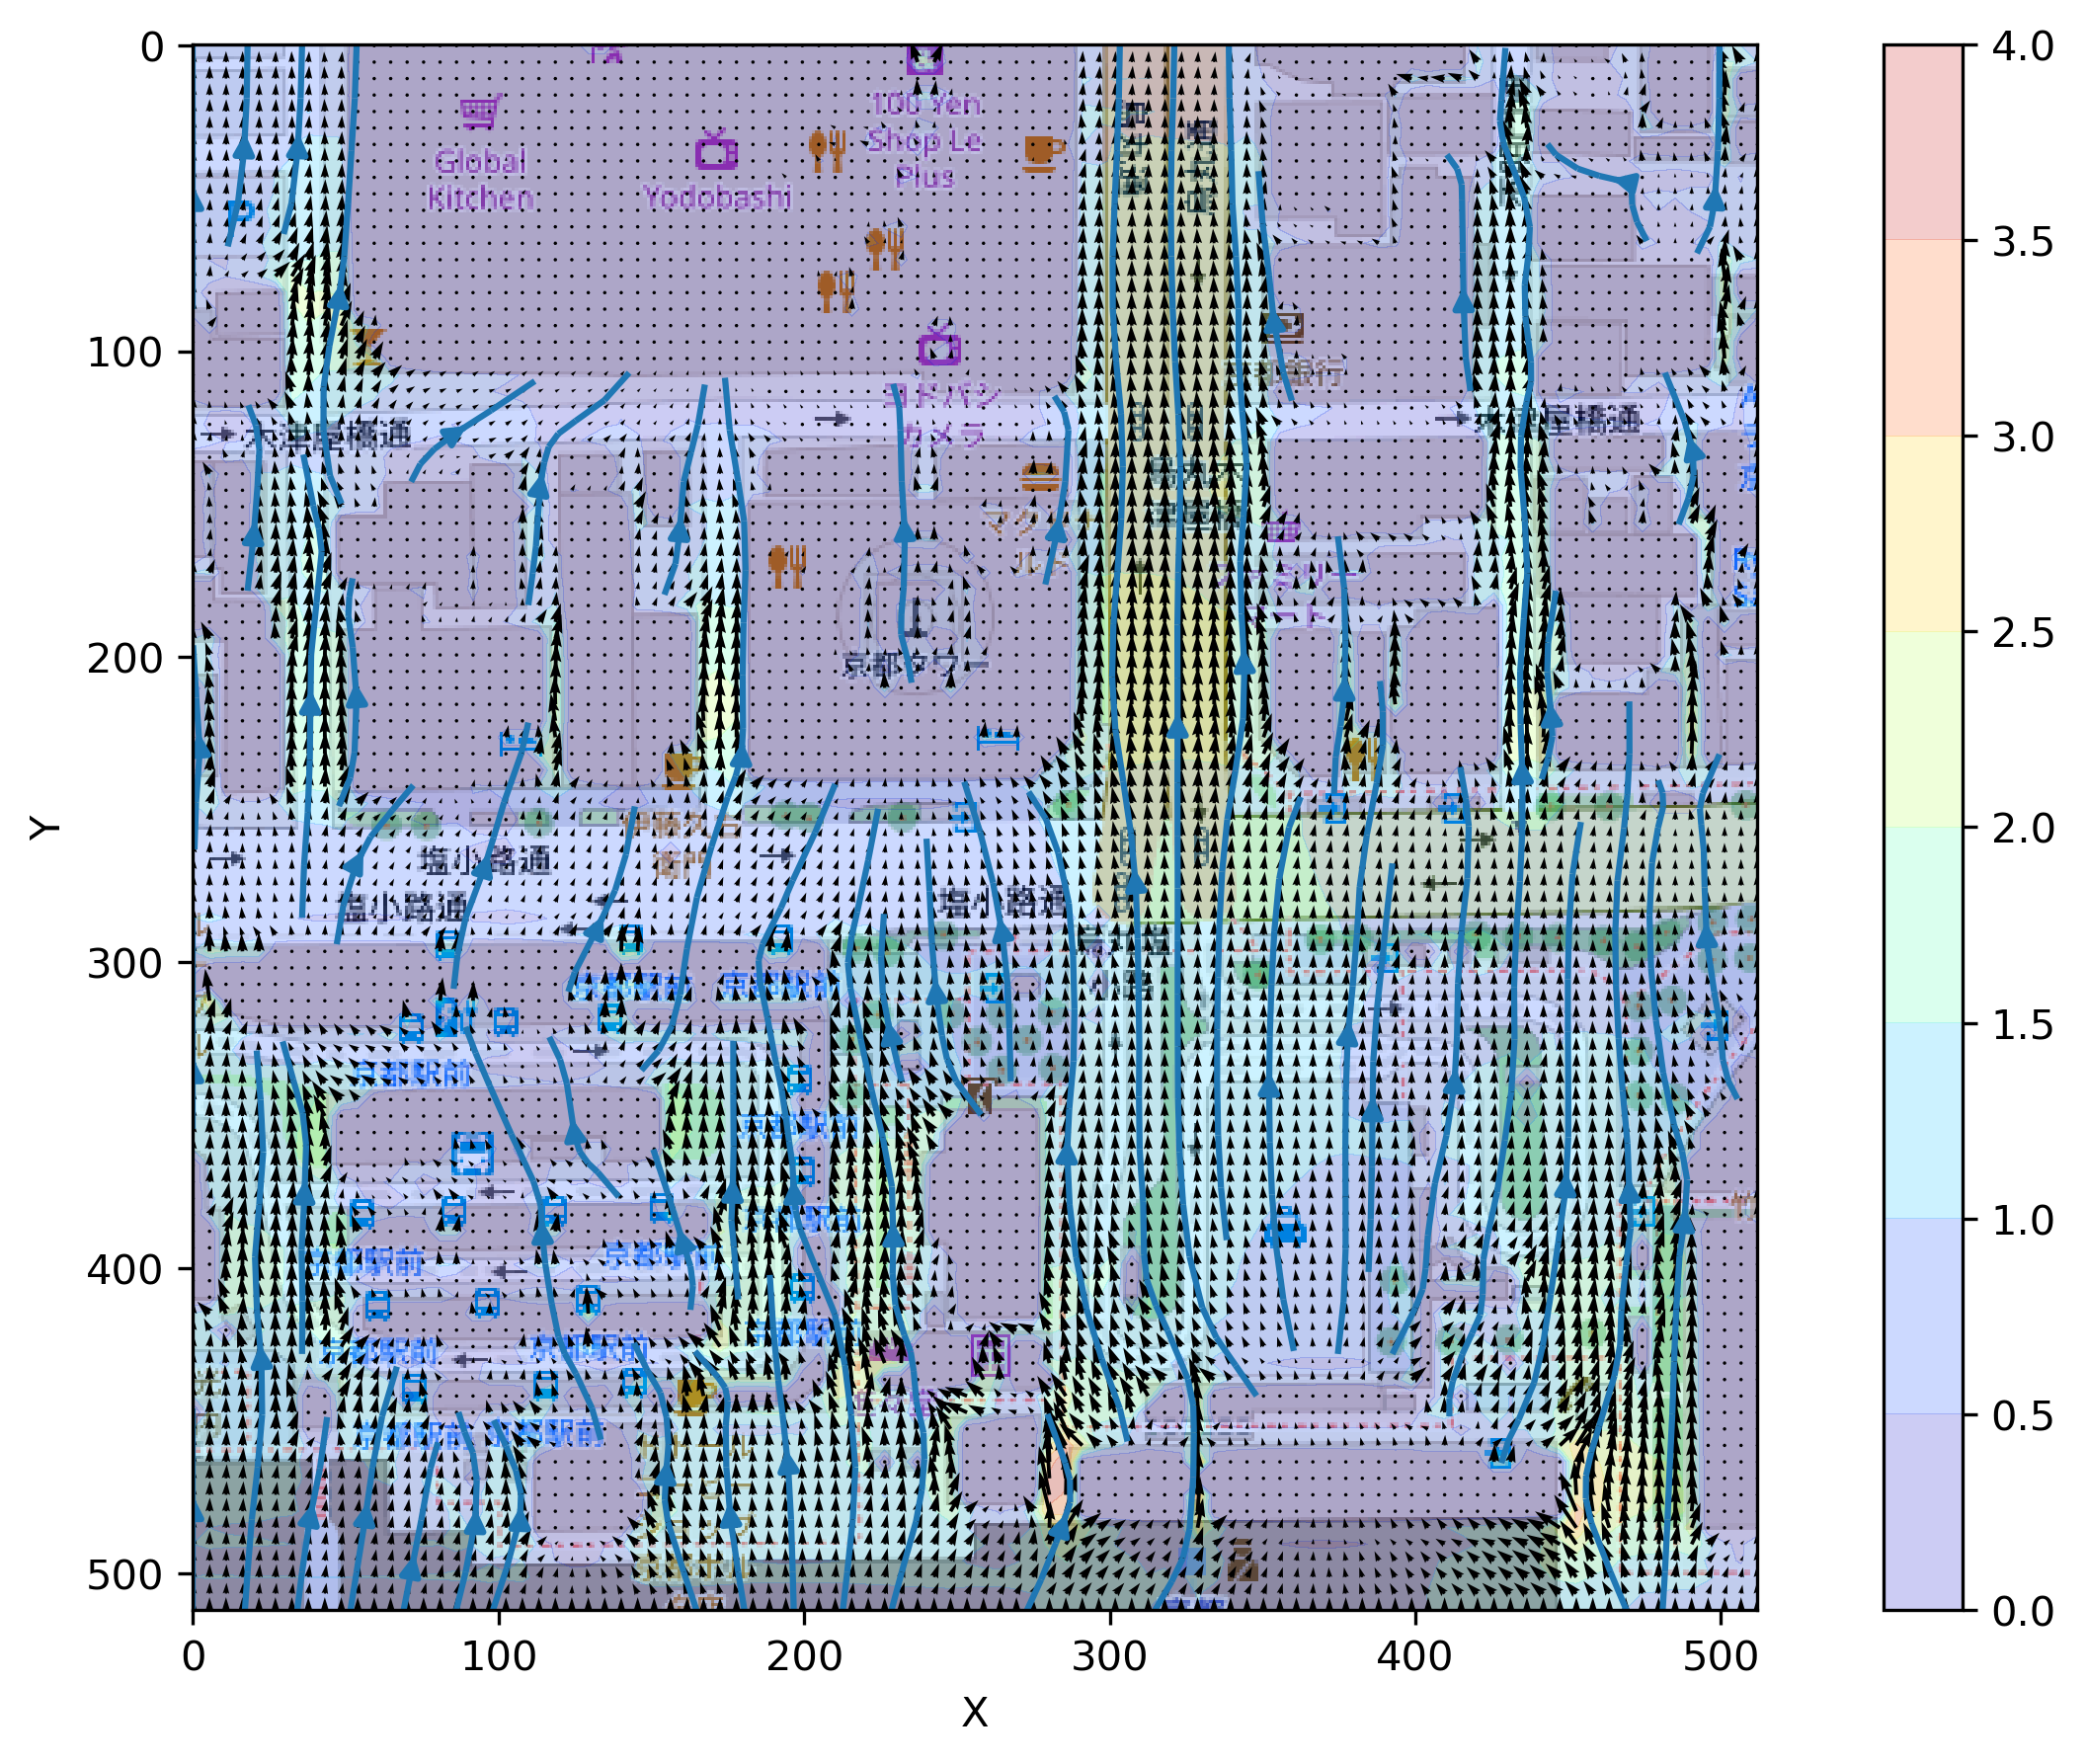

In [13]:
plot_flow(u, v, ua, map_image)

# マスクの生成


## 理想的な建物配置

In [14]:
npx = 512
npy = 512
map_image = np.zeros((npy, npx, 3), dtype='uint8')
for i in range(1,5):
    map_image[100 * i:100 * i + 20, :] = 255
for j in range(1,5):
    map_image[:, 100 * j:100 * j + 20] = 255

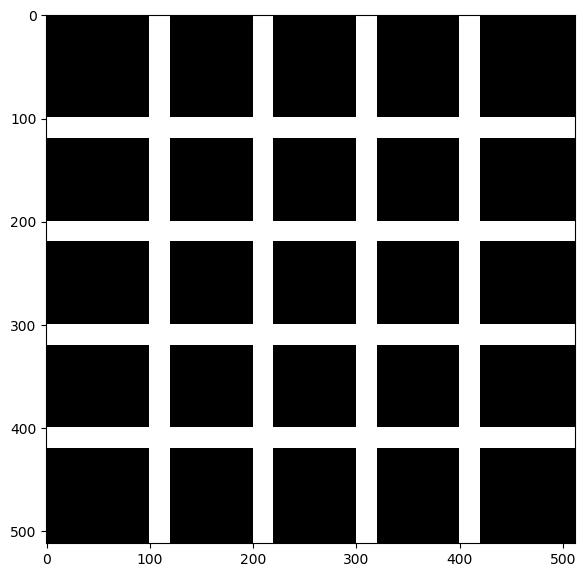

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7), dpi=100)
plt.imshow(map_image)

In [16]:
import numpy as np
import cv2
def mask_map_bw(map_image):
    gray = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY) # convert RGB/BGR to HSV (hue saturation value)
    th, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) # building = 255, other = 0
    masked_map_image = cv2.bitwise_and(map_image, map_image, mask)
    return masked_map_image, mask

In [17]:
import cv2
nx = 96
ny = nx * npy // npx
low_image = cv2.resize(map_image, (ny, nx))
masked_low_image, low_mask = mask_map_bw(low_image)

In [18]:
u, v, p, ua = run_ns2d(speed, angle, low_mask)

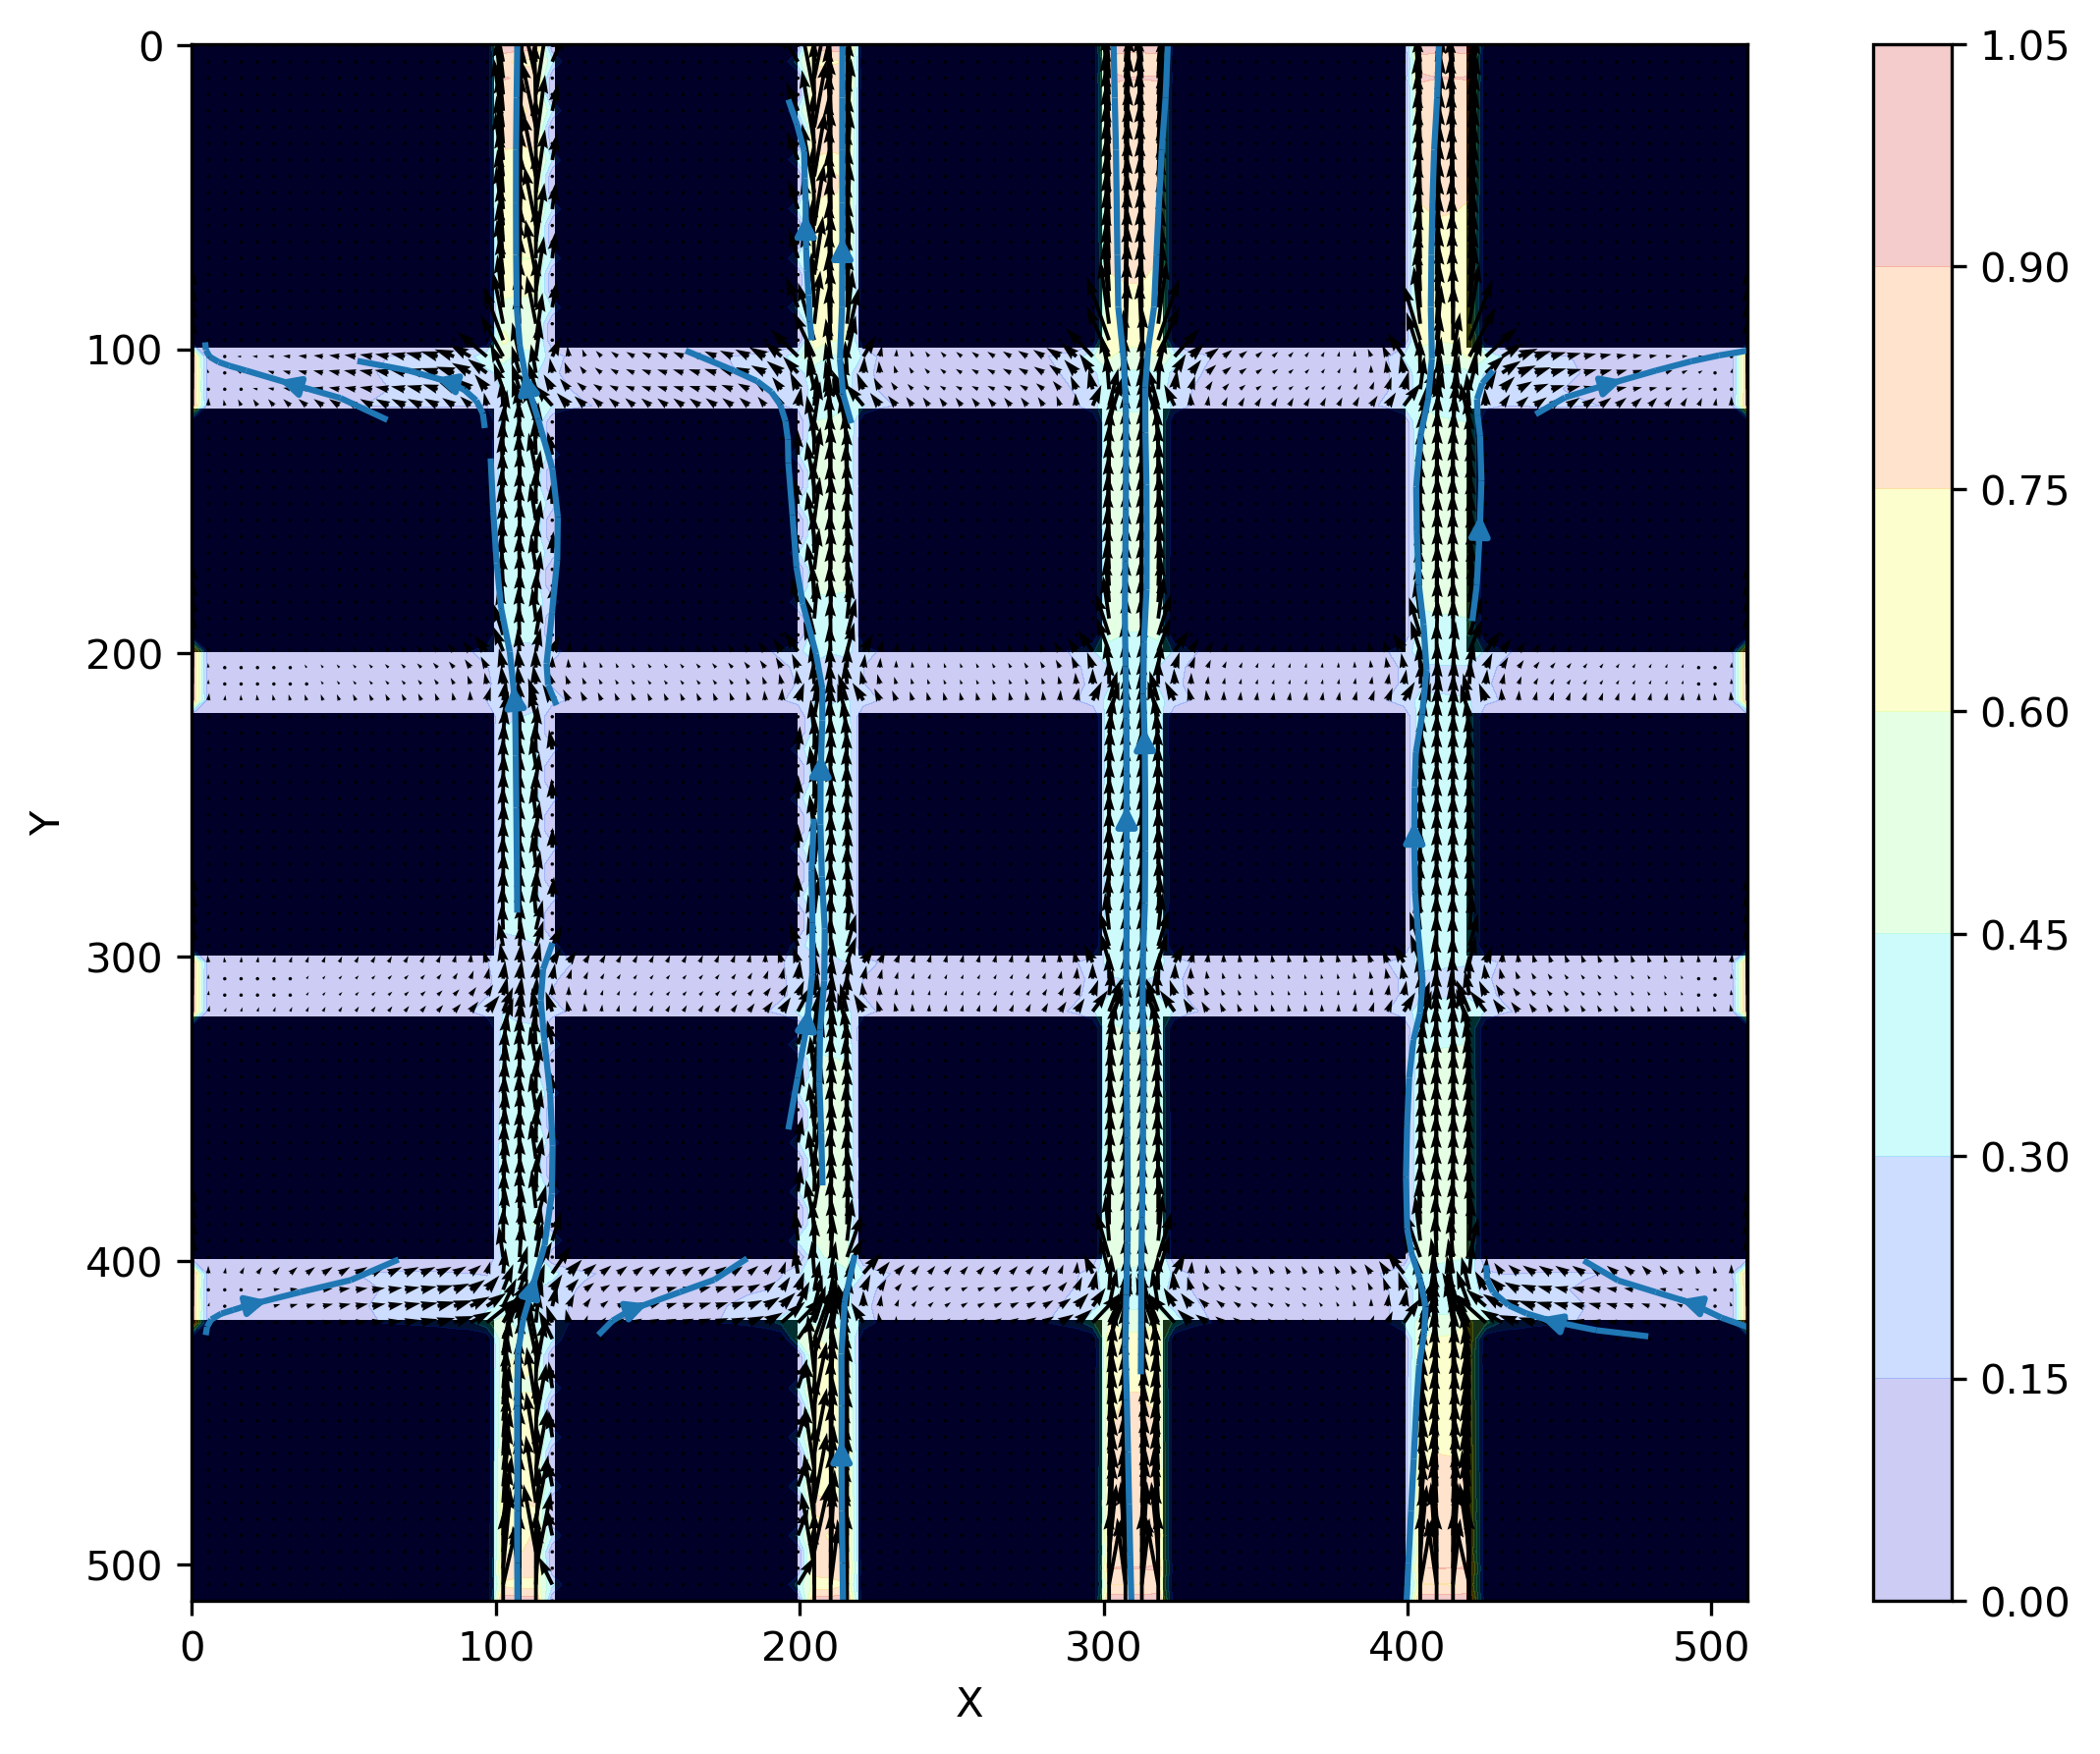

In [19]:
plot_flow(u, v, ua, map_image)

## 基盤地図情報の利用

OpenStreetMapでは，建物の情報がない地域がある。国土地理院の基盤図情報からマスクを作成すればよい。ここでは手順のみ示す。

1. [基盤地図情報](https://fgd.gsi.go.jp/download/menu.php)に登録する。
1. `基本項目`から必要なzipファイルをダウンロードする。zipの解凍は不要。
1. [基盤地図情報ビューア](https://fgd.gsi.go.jp/download/documents.html)（Windows版）にzipファイルを読む。
1. `レイヤーリスト`で建物以外チェックを外す。
1. `設定 > 表示設定`で建物の色を黒にする。
1. 計算したい領域をマウスで選択して画像として保存する。

`cv2.imread()`で読んだ画像はRGBなので，グレーに変換し，2値化する。閾値以下のグレーは，マスクに影響しないので道路をグレーで描いておくと見やすいかもしれない。

* [基盤地図情報ビューア マニュアル](https://fgd.gsi.go.jp/otherdata/tool/fgdv_manual.pdf)